## Wasserstein GAN-GP Implementation

Based on the paper: <i>Improved Training of Wasserstein GANs</i>. There is a good reference [here](https://github.com/eriklindernoren/Keras-GAN/blob/master/wgan_gp/wgan_gp.py).

In [1]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.constraints import Constraint
from tensorflow.keras.layers import Input,Dense,Reshape,Dropout,BatchNormalization,Activation,UpSampling2D,Embedding
from tensorflow.keras.layers import BatchNormalization,Conv2D,LeakyReLU,Flatten,Conv2DTranspose,Concatenate,LayerNormalization
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.losses import BinaryCrossentropy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
tf.keras.backend.set_floatx('float32')

import warnings
warnings.filterwarnings('ignore')

### Data Cleaning

In [2]:
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')
x_train = x_train[y_train <= 3] # using numbers 0,1,2,3
y_train = y_train[y_train <= 3]
y_train = y_train.astype("int32")
y_train = np.expand_dims(y_train,axis=-1)
x_train = (x_train-127.5)/127.5 # scaling the images
x_train = np.expand_dims(x_train,axis=-1)
x_train = x_train[:24750]
y_train = y_train[:24750]
print(x_train.shape,y_train.shape)

(24750, 28, 28, 1) (24750, 1)


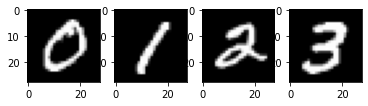

In [3]:
plt.subplot(1,4,1)
plt.imshow(np.squeeze(x_train[0]),cmap="gray")
plt.subplot(1,4,2)
plt.imshow(np.squeeze(x_train[1]),cmap="gray")
plt.subplot(1,4,3)
plt.imshow(np.squeeze(x_train[2]),cmap="gray")
plt.subplot(1,4,4)
plt.imshow(np.squeeze(x_train[4]),cmap="gray")
plt.show()

### Model Implementation

Brief description: we want to <b>maximize</b> the critic score for <u>fake</u> images and <b>minimize</b> the critic score for <u>real</u> images; therefore loss_fake-img = <b>-1</b>\*critic_score while loss_real-img = critic_score (this is intuitive when remembering gradient descent is minimizing -1\*critic_score_fake-img + critic_score_real-img).

In [4]:
def get_generator(noise_dim=100):
    """ generator implementation
    """
    z = Input(shape=(noise_dim))
    h = Dense(7*7*256)(z)
    h = LeakyReLU(0.2)(h)
    h = Reshape((7,7,256))(h)
    
    h = UpSampling2D()(h)
    h = Conv2D(filters=128,kernel_size=4,strides=1,padding='same',activation=None)(h)
    h = BatchNormalization()(h)
    h = LeakyReLU(0.2)(h)
    h = UpSampling2D()(h)
    h = Conv2D(filters=128,kernel_size=4,strides=1,padding='same',activation=None)(h)
    h = BatchNormalization()(h)
    h = LeakyReLU(0.2)(h)
    h = Conv2D(filters=1,kernel_size=4,strides=1,padding='same',activation=None)(h)
    h = Activation('tanh')(h)
    
    model = Model(inputs=z,outputs=h)
    return model

In [5]:
def get_discriminator():
    """ discriminator(critic) implementation
    """
    x = Input(shape=(28,28,1))

    h = Conv2D(filters=64,kernel_size=4,strides=2,padding='same',activation=None)(x)
    h = LayerNormalization()(h)
    h = LeakyReLU(0.2)(h)
    h = Conv2D(filters=64,kernel_size=4,strides=2,padding='same',activation=None)(h)
    h = LayerNormalization()(h)
    h = LeakyReLU(0.2)(h)
    h = Flatten()(h)
    h = Dense(1,activation=None)(h) # linear
    
    model = Model(inputs=x,outputs=h)
    return model

In [6]:
def wasserstein_loss(y_true,y_pred):
    """ loss implementation
    """
    return K.mean(y_true*y_pred)

In [7]:
@tf.function
def train_discriminator(discriminator,optimizer,real_x,real_y,fake_x,fake_y,interpolated_x,lam=10):
    """ training the discriminator/critic
        -gradient penalty to constrain gradient norm of critic output w/ respect to interpolated input
    """
    with tf.GradientTape() as tape:
        pred_real = discriminator(real_x)
        pred_fake = discriminator(fake_x)
        disc_loss_real = wasserstein_loss(real_y,pred_real)
        disc_loss_fake = wasserstein_loss(fake_y,pred_fake)
        disc_loss = disc_loss_real+disc_loss_fake
        
        with tf.GradientTape() as tape2: # calculating gradient penalty (L2 norm)
            interpolated_out = discriminator(interpolated_x)
        gradients = tape2.gradient(interpolated_out,interpolated_x) # gradient w/ respect to interpolated input
        grad_norm = K.sqrt(K.sum(K.square(gradients),axis=-1))
        grad_penalty = tf.reduce_mean(K.square(grad_norm-1))
        
        loss = disc_loss+(lam*grad_penalty)
        
    gradients = tape.gradient(loss, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(gradients, discriminator.trainable_variables))
    return loss

In [8]:
def adversarial_model(generator,discriminator,noise_dim=100,optimizer=Adam(lr=0.0001,beta_1=0.0,beta_2=0.9)):
    """ compiling adversarial model - used to train generator
    """
    z = Input(shape=(noise_dim))
    gen = generator(z)
    out = discriminator(gen)
    
    model = Model(inputs=z,outputs=out)
    model.compile(loss=wasserstein_loss,optimizer=optimizer)
    return model

In [9]:
discriminator = get_discriminator()
generator = get_generator()
adversarial = adversarial_model(generator,discriminator)

### Model Training

The noise prior z~N(0,1)

In [10]:
def get_weighted_avg(real,fake):
    """ gets randomly weighted average of real and fake examples
    """
    interpolated_x = []
    batch_size = len(real)
    weights = np.random.uniform(0.0,1.0,size=batch_size)
    for i in range(batch_size):
        interpolated_x.append((weights[i]*real[i])+((1-weights[i])*fake[i]))
    interpolated_x = np.asarray(interpolated_x).astype("float32")
    return interpolated_x

Epoch 1:


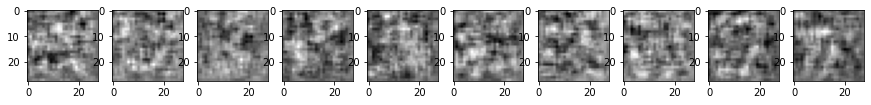

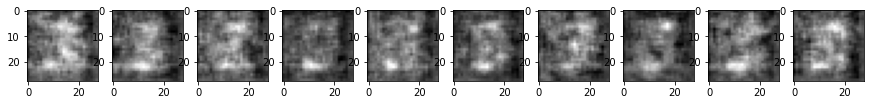

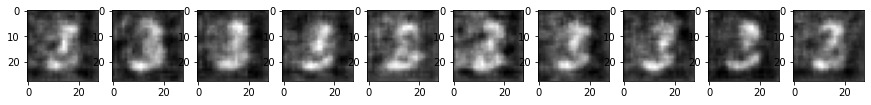

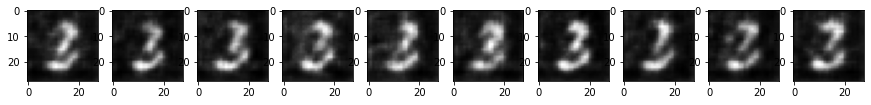

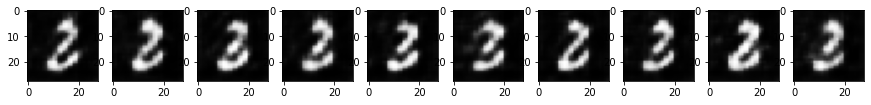

In [ ]:
num_epochs=100
batch_size=50
n_critic=5
disc_optimizer = Adam(lr=0.0001,beta_1=0.0,beta_2=0.9)

for epoch_i in range(num_epochs):
    all_a_losses = []
    all_d_losses = []
    print("Epoch {}:".format(epoch_i+1))

    for i in range(0,len(x_train)-batch_size*(n_critic-1),batch_size):
        x_subset = x_train[i:i+batch_size*n_critic]

        # training the discriminator:
        discriminator.trainable=True
        for nc_i in range(n_critic):
            z = np.random.normal(0.0,1.0,size=(int(batch_size/2),100))
            x_gen = generator(z)
            interpolated_x = get_weighted_avg(x_subset[nc_i*batch_size:nc_i*batch_size+int(batch_size/2)],x_gen)
            interpolated_x = tf.Variable(tf.convert_to_tensor(interpolated_x)) # watchable by grad tape

            # training critic
            real_x = x_subset[nc_i*batch_size:nc_i*batch_size+int(batch_size/2)]
            real_y = np.ones((int(batch_size/2),1)).astype("float32")
            fake_x = x_gen
            fake_y = -1*np.ones((int(batch_size/2),1)).astype("float32")
            d_loss = train_discriminator(discriminator,disc_optimizer,real_x,real_y,fake_x,fake_y,interpolated_x,lam=10)
            all_d_losses.append(float(d_loss))

        # training the generator:
        y = np.ones([batch_size,1]) # we switch the labels here to maximize the domain-confusion
        z = np.random.normal(0.0,1.0,size=(batch_size,100))
        discriminator.trainable=False
        a_loss = adversarial.train_on_batch(z,y)
        all_a_losses.append(float(a_loss))

        if i%2000 == 0:
            plt.figure(figsize=(15,4))
            for i in range(10):
                this_noise = np.random.normal(0.0,1.0,size=(1,100))
                gen = generator(this_noise).numpy()
                gen.shape=(28,28)
                plt.subplot(1,10,i+1)
                plt.imshow(gen,cmap="gray")
            plt.show()

    print("gen. loss:{}; disc. loss:{};".format(sum(all_a_losses)/len(all_a_losses),sum(all_d_losses)/len(all_d_losses)))
    print("--------------------------------------------------------------------------------------------------")
    print("--------------------------------------------------------------------------------------------------")
    print("--------------------------------------------------------------------------------------------------")